# Table of Contents
- [Data gathering and preparation](#prep-start)
    - [FRED data](#prep-fred)
    - [FDIC data](#prep-fdic)
    - [Merging FRED and FDIC data](#prep-merge)
- [Initial data exploration](#explo-start)
    - [Data distributions and outlier detection](#explo-outlier)
    - [Summary statistics](#explo-summary)
    - [Correlation heatmap](#explo-corr)
- [Unsupervised modelling exploration](#unsupervised)
- [Supervised modelling and analysis](#supervised)
    - [Results and interpretation](#supervised-results)

In [1]:
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyarrow.feather import read_feather, write_feather

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 50)

In banking, forecasting deposit movements helps to manage cash flows and inform lending and investing decisions. Our goal is specifically to forecast bank deposit size using key macroeconomic indicators and bank-level data.

[Github repository](https://github.com/hughdingb58/deposit_size_prediction)

<a id="prep-start"></a>
# Data gathering and preparation

<a id="prep-fred"></a>
## FRED data

<a id="prep-fdic"></a>
## FDIC data

FDIC data is gathered from its [API](https://banks.data.fdic.gov/docs/).

In [3]:
fdic_url = "https://banks.data.fdic.gov/api/"

### Bank metadata

In [4]:
institutions_url = fdic_url + "institutions"

institutions_params = {
    "filters": "ACTIVE:1",
    "sort_by": "OFFICES",
    "sort_order": "DESC",
    "limit": 10000,
    "format": "json"
}

# Get list of institutions from API
res = requests.get(institutions_url, params = institutions_params)
institutions_data = res.json()["data"]

In [5]:
# Read data into list
institutions_list = []
for row in institutions_data:
    curr_bank = pd.DataFrame(row["data"], index = [0])
    institutions_list.append(curr_bank)

# Bind list into table
institutions_full = pd.concat(institutions_list, axis = 0).reset_index(drop = True)

In [6]:
# Keep only relevant columns
institutions = institutions_full[["NAMEHCR", "STNAME", "CITY", "ZIP"]].drop_duplicates()
institutions = institutions[institutions["NAMEHCR"] != ""].reset_index(drop = True)
institutions["ZIP"] = institutions["ZIP"].astype(str)
institutions.head()

,NAMEHCR,STNAME,CITY,ZIP
0,JPMORGAN CHASE&CO,Ohio,Columbus,43240
1,WELLS FARGO&COMPANY,South Dakota,Sioux Falls,57104
2,BANK OF AMERICA CORP,North Carolina,Charlotte,28202
3,PNC FINL SERVICES GROUP INC,Delaware,Wilmington,19801
4,U S BCORP,Ohio,Cincinnati,45202


In [7]:
print("Number of active institutions: " + str(institutions.shape[0]))

Number of active institutions: 3816


### Financial data

In [8]:
fields = [
    "NAMEHCR", # Bank name
    "ZIP", # Bank location
    "REPDTE", # Reporting date
    "ASSET", # Total assets
    "NETINCQ", # Quarterly net income
    "NETINCQR", # Quarterly net income ratio
    "OFFOA", # Number of US offices
    "OFFFOR", # Number of foreign offices
    "ROAQ", # Return on assets
    "ROEQ", # Quarterly return on equity
    "EINTXQA", # Total interest expense quarterly
    "EINTXQR", # Total interest expense quarterly ratio
    "NONIXQA", # Total interest expense quarterly
    "NONIXQR", # Total interest expense quarterly ratio
    "DEP", # Total deposits
    "DEPR" # Total deposits ratio
]

fields_str = ",".join(fields)
fields_sum_str = ",".join(fields[3:])
print(fields_str)
print(fields_sum_str)

NAMEHCR,ZIP,REPDTE,ASSET,NETINCQ,NETINCQR,OFFOA,OFFFOR,ROAQ,ROEQ,EINTXQA,EINTXQR,NONIXQA,NONIXQR,DEP,DEPR
ASSET,NETINCQ,NETINCQR,OFFOA,OFFFOR,ROAQ,ROEQ,EINTXQA,EINTXQR,NONIXQA,NONIXQR,DEP,DEPR


In [9]:
financials_url = fdic_url + "financials"

financials_list = []

# Loop through banks
for i in range(institutions.shape[0]):
    institution_row = institutions.iloc[i]
    financials_params = {
        "filters": 'NAMEHCR:"' + str(institution_row["NAMEHCR"]) + '",ZIP:"' + str(institution_row["ZIP"]) + '"',
        "fields": fields_str,
        "sort_by": "REPDTE",
        "sort_order": "DESC",
        "limit": 10000,
        "agg_term_fields": "NAMEHCR,ZIP,REPDTE",
        "agg_sum_fields": fields_sum_str,
        "format": "json"
    }

    # Get list of institutions from API
    res = requests.get(financials_url, params = financials_params)
    financials_data = res.json()["data"]
    
    # Read data into list
    for row in financials_data:
        curr_bank = pd.DataFrame(row["data"], index = [0])
        financials_list.append(curr_bank)

    # To keep track of progress
    if (i % 200) == 0:
        print("row " + str(i) + ": " + str(institution_row["NAMEHCR"]))


row 0: JPMORGAN CHASE&CO
row 50: RENASANT CORP
row 100: PINNACLE BCORP INC
row 150: SUMMIT FINANCIAL GROUP INC
row 200: FIRST OF LONG ISLAND CORP THE
row 250: BANK OF NY MELLON CORP THE
row 300: ENTERPRISE BCORP INC
row 350: FRANKLIN FINL SERVICES CORP
row 400: CONSUMERS BCORP INC
row 450: ROYAL BANCSHARES INC
row 500: ALLIANCE BANCSHARES INC
row 550: TENNESSEE STATE BANCSHARES INC
row 600: SOUTHEAST BANCSHARES INC
row 650: CHINA INVESTMENT CORP
row 700: DECATUR INVESTMENT INC
row 750: DAIRY STATE BCORP INC
row 800: MONTGOMERY BCORP INC
row 850: VISION BANCSHARES INC
row 900: ORION BCORP INC
row 950: FIRST BCORP OF INDIANA INC
row 1000: MID-MISSOURI HOLDING CO INC
row 1050: MBT BANCSHARES INC
row 1100: CITIZENS CORP
row 1150: NORTHERN WI BK HOLDING CO INC
row 1200: FARMERS&MERCHANTS BANCSHARES
row 1250: METROPOLITAN BANK HOLDING CORP
row 1300: HIGH POINT FINL SERVICES INC
row 1350: ALLIANCE BCORP
row 1400: FIVE STAR BCORP
row 1450: TRUNORTH BCORP MHC
row 1500: MARION BANCSHARES INC
row

In [10]:
# Bind list into table
financials_data = pd.concat(financials_list, axis = 0).reset_index(drop = True)
financials_data["ZIP"] = financials_data["ZIP"].astype(str)

In [11]:
financials = pd.merge(institutions, financials_data, on = ["NAMEHCR", "ZIP"])
# Set more descriptive column names
financials.columns = ["name", "state", "city", "zip", "date", "total_assets", "roa_quarterly", "net_income_quarterly_ratio",
                      "total_interest_expense_quarterly", "total_deposits", "non_interest_expense_quarterly", "roe_quarterly",
                      "offices_foreign", "net_income", "offices_us", "total_deposits_ratio",
                      "total_interest_expense_quarterly_ratio", "non_interest_expense_quarterly_ratio", "id"]
# Clean date column
financials["date"] = pd.to_datetime(financials["date"], format = "%Y%m%d")
financials.sample(n = 10, random_state = 0)

,name,state,city,zip,date,total_assets,roa_quarterly,net_income_quarterly_ratio,total_interest_expense_quarterly,total_deposits,non_interest_expense_quarterly,roe_quarterly,offices_foreign,net_income,offices_us,total_deposits_ratio,total_interest_expense_quarterly_ratio,non_interest_expense_quarterly_ratio,id
400383,CITY NATIONAL BANKCORP INC,Illinois,Metropolis,62960,1994-09-30,87617,1.43,1.425520,2388,74030,1680,10.63,0,307,0,84.492735,2.772103,1.950223,3814_19940930
407396,CLOVIS BANCSHARES INC,New Mexico,Clovis,88101,2006-06-30,92041,1.17,1.170686,1632,82911,2356,14.05,0,250,0,90.080508,1.910560,2.758136,57022_20060630
120691,CARROLL FINANCIAL SERVICES INC,Tennessee,Huntingdon,38344,2004-03-31,153863,1.25,1.245555,2120,134731,4172,11.99,0,475,0,87.565562,1.389777,2.734975,2380_20040331
20806,HANMI FINANCIAL CORP,California,Los Angeles,90010,2006-09-30,3736803,2.08,2.079663,109048,2975219,75424,14.14,0,19128,0,79.619370,2.964020,2.050091,24170_20060930
339845,HOMETOWN BANCSHARES INC,Alabama,Hamilton,35570,2007-03-31,45092,0.42,0.420605,1416,38467,1400,2.95,0,47,0,85.307815,3.167962,3.132166,57569_20070331
122982,WINTRUST FINANCIAL CORP,Illinois,Lake Forest,60045,1998-06-30,390153,0.95,0.949949,15048,362513,7320,16.29,0,951,0,92.915600,3.757843,1.827978,27589_19980630
372650,WB&T BANKSHARES INC,Georgia,Brunswick,31520,2022-12-31,214753,1.41,1.411891,1708,198243,4988,23.99,0,737,0,92.312098,0.818015,2.388912,16283_20221231
305086,WILSON BANCSHARES INC,Missouri,Weston,64098,1988-03-31,29521,1.40,1.398798,1468,26729,956,18.8,0,112,0,90.542326,4.583561,2.984935,1418_19880331
259229,FIRST BCORP INC,Kentucky,Campbellsville,42718,1994-09-30,60202,1.10,1.104063,1576,50830,2000,10.53,0,166,0,84.432411,2.620487,3.325491,15675_19940930
35271,CITIZENS BANCSHARES CORP,South Carolina,Olanta,29114,1996-03-31,97748,1.81,1.814723,3704,84861,2960,16.5,0,440,0,86.816099,3.819167,3.052034,15932_19960331


Most data values look reasonable, but the ID doesn't seem meaningful, and the office counts don't seem to be properly filled in, so we will exclude those.

In [12]:
# Remove ID column
financials = financials.drop(["id", "offices_foreign", "offices_us"], axis = 1)
# Cache values
write_feather(financials, "fdic_financials.feather")

In [14]:
financials = read_feather("fdic_financials.feather")

<a id="prep-merge"></a>
## Merging FRED and FDIC data

In [86]:
df_full = financials
# Only interested in post-2000 data
df_2000 = df_full[df_full["date"] >= "2000-01-01"].reset_index(drop = True)

<a id="explo-start"></a>
# Initial data exploration

<a id="explo-outlier"></a>
## Data distributions and outlier detection

We first plot a histogram of our outcome variable, deposit size.

<Axes: xlabel='total_deposits', ylabel='Count'>

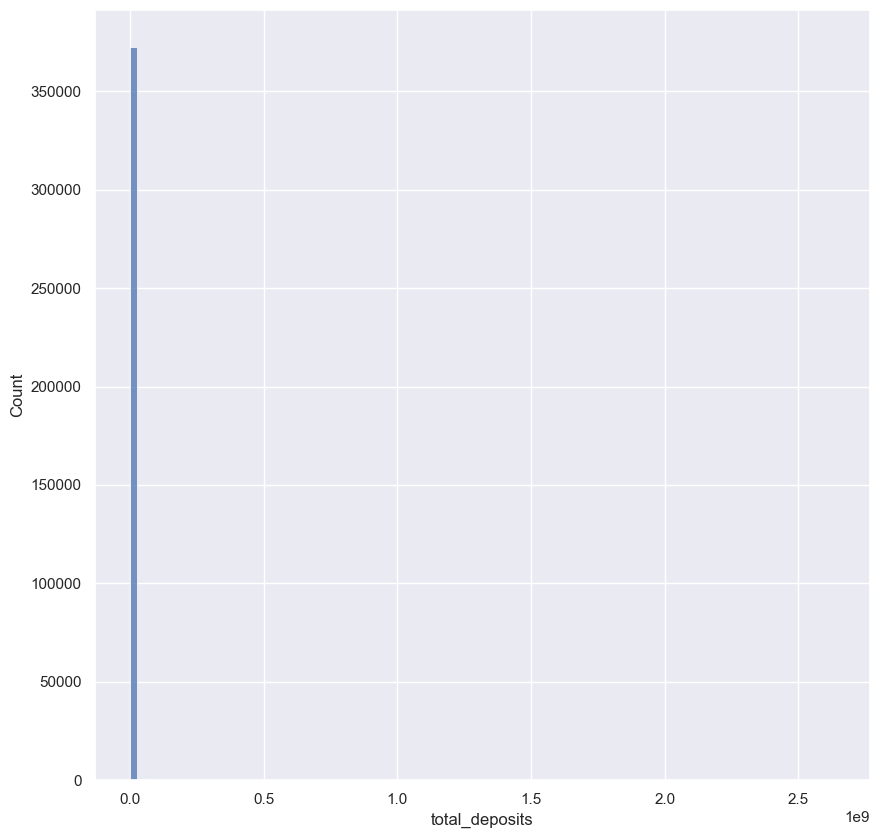

In [87]:
sns.histplot(df_2000, x = "total_deposits", bins = 100)

We see that the vast majority of banks have deposit sizes that are far smaller than the largest banks. However, since our analysis is from a macroeconomic perspective, we are more interested in the larger banks. We aggregate the smaller banks so that they do not overpower the larger ones in our analysis.

In [88]:
# Use total deposits >= 2020 to decide bank size
bank_rankings = df_2000[df_2000["date"] >= "2020-01-01"].groupby(["name", "zip"]). \
  agg({"total_deposits": "sum"}).sort_values("total_deposits", ascending = False).reset_index()
bank_rankings.columns.values[2] = "deposit_sum_post_2020"
bank_rankings.head(20)

,name,zip,deposit_sum_post_2020
0,JPMORGAN CHASE&CO,43240,76415604000
1,WELLS FARGO&COMPANY,57104,70069329000
2,BANK OF AMERICA CORP,28202,63303262000
3,CITIGROUP INC,57108,21114995969
4,U S BCORP,45202,7450869845
5,BANK OF NY MELLON CORP THE,10007,6926352000
6,TRUIST FINANCIAL CORP,28202,6586996000
7,PNC FINL SERVICES GROUP INC,19801,6569478059
8,TORONTO-DOMINION BANK THE,19808,5840438231
9,CHARLES SCHWAB CORP THE,76262,5579947000


We decide on thresholds for how to aggregate for these banks through manual inspection.

In [89]:
df_2000 = pd.merge(df_2000, bank_rankings)
df_2000["category"] = np.select(
    [df_2000["deposit_sum_post_2020"] >= 3000000000,
     df_2000["deposit_sum_post_2020"] >= 1500000000,
     df_2000["deposit_sum_post_2020"] >= 100000000],
    [df_2000["name"], "Other large banks", "Medium-sized banks"],
    default = "Small banks"
)

df_2000.groupby(["category"]).agg({"deposit_sum_post_2020": "sum"}).sort_values("deposit_sum_post_2020", ascending = False)

,deposit_sum_post_2020
category,
WELLS FARGO&COMPANY,24804542466000
Medium-sized banks,17323629569946
JPMORGAN CHASE&CO,11768003016000
BANK OF AMERICA CORP,7216571868000
Small banks,4171986980527
Other large banks,2370102586629
MORGAN STANLEY,1155899288000
FIRST CITIZENS BANCSHARES INC,1117150813728
U S BCORP,685480025740


These thresholds seem reasonable (the three aggregate categories are comparable to the largest banks), so we will use them for now.

In [90]:
df_2000_agg = df_2000.groupby(["category", "state", "city", "zip", "date"]).agg({
    "total_assets": "sum",
    "roa_quarterly": "mean",
    "net_income_quarterly_ratio": "mean",
    "total_interest_expense_quarterly": "sum",
    "total_deposits": "sum",
    "non_interest_expense_quarterly": "sum",
    "roe_quarterly": "mean",
    "net_income": "sum",
    "total_deposits_ratio": "mean",
    "total_interest_expense_quarterly_ratio": "mean",
    "non_interest_expense_quarterly_ratio": "mean"
}).reset_index()

Now that we have reduced our df to banks (and groups of banks) we are confident we are interested in, we generate histograms for each metric, each across a period of 5 years, to visually inspect for unusual distributions.

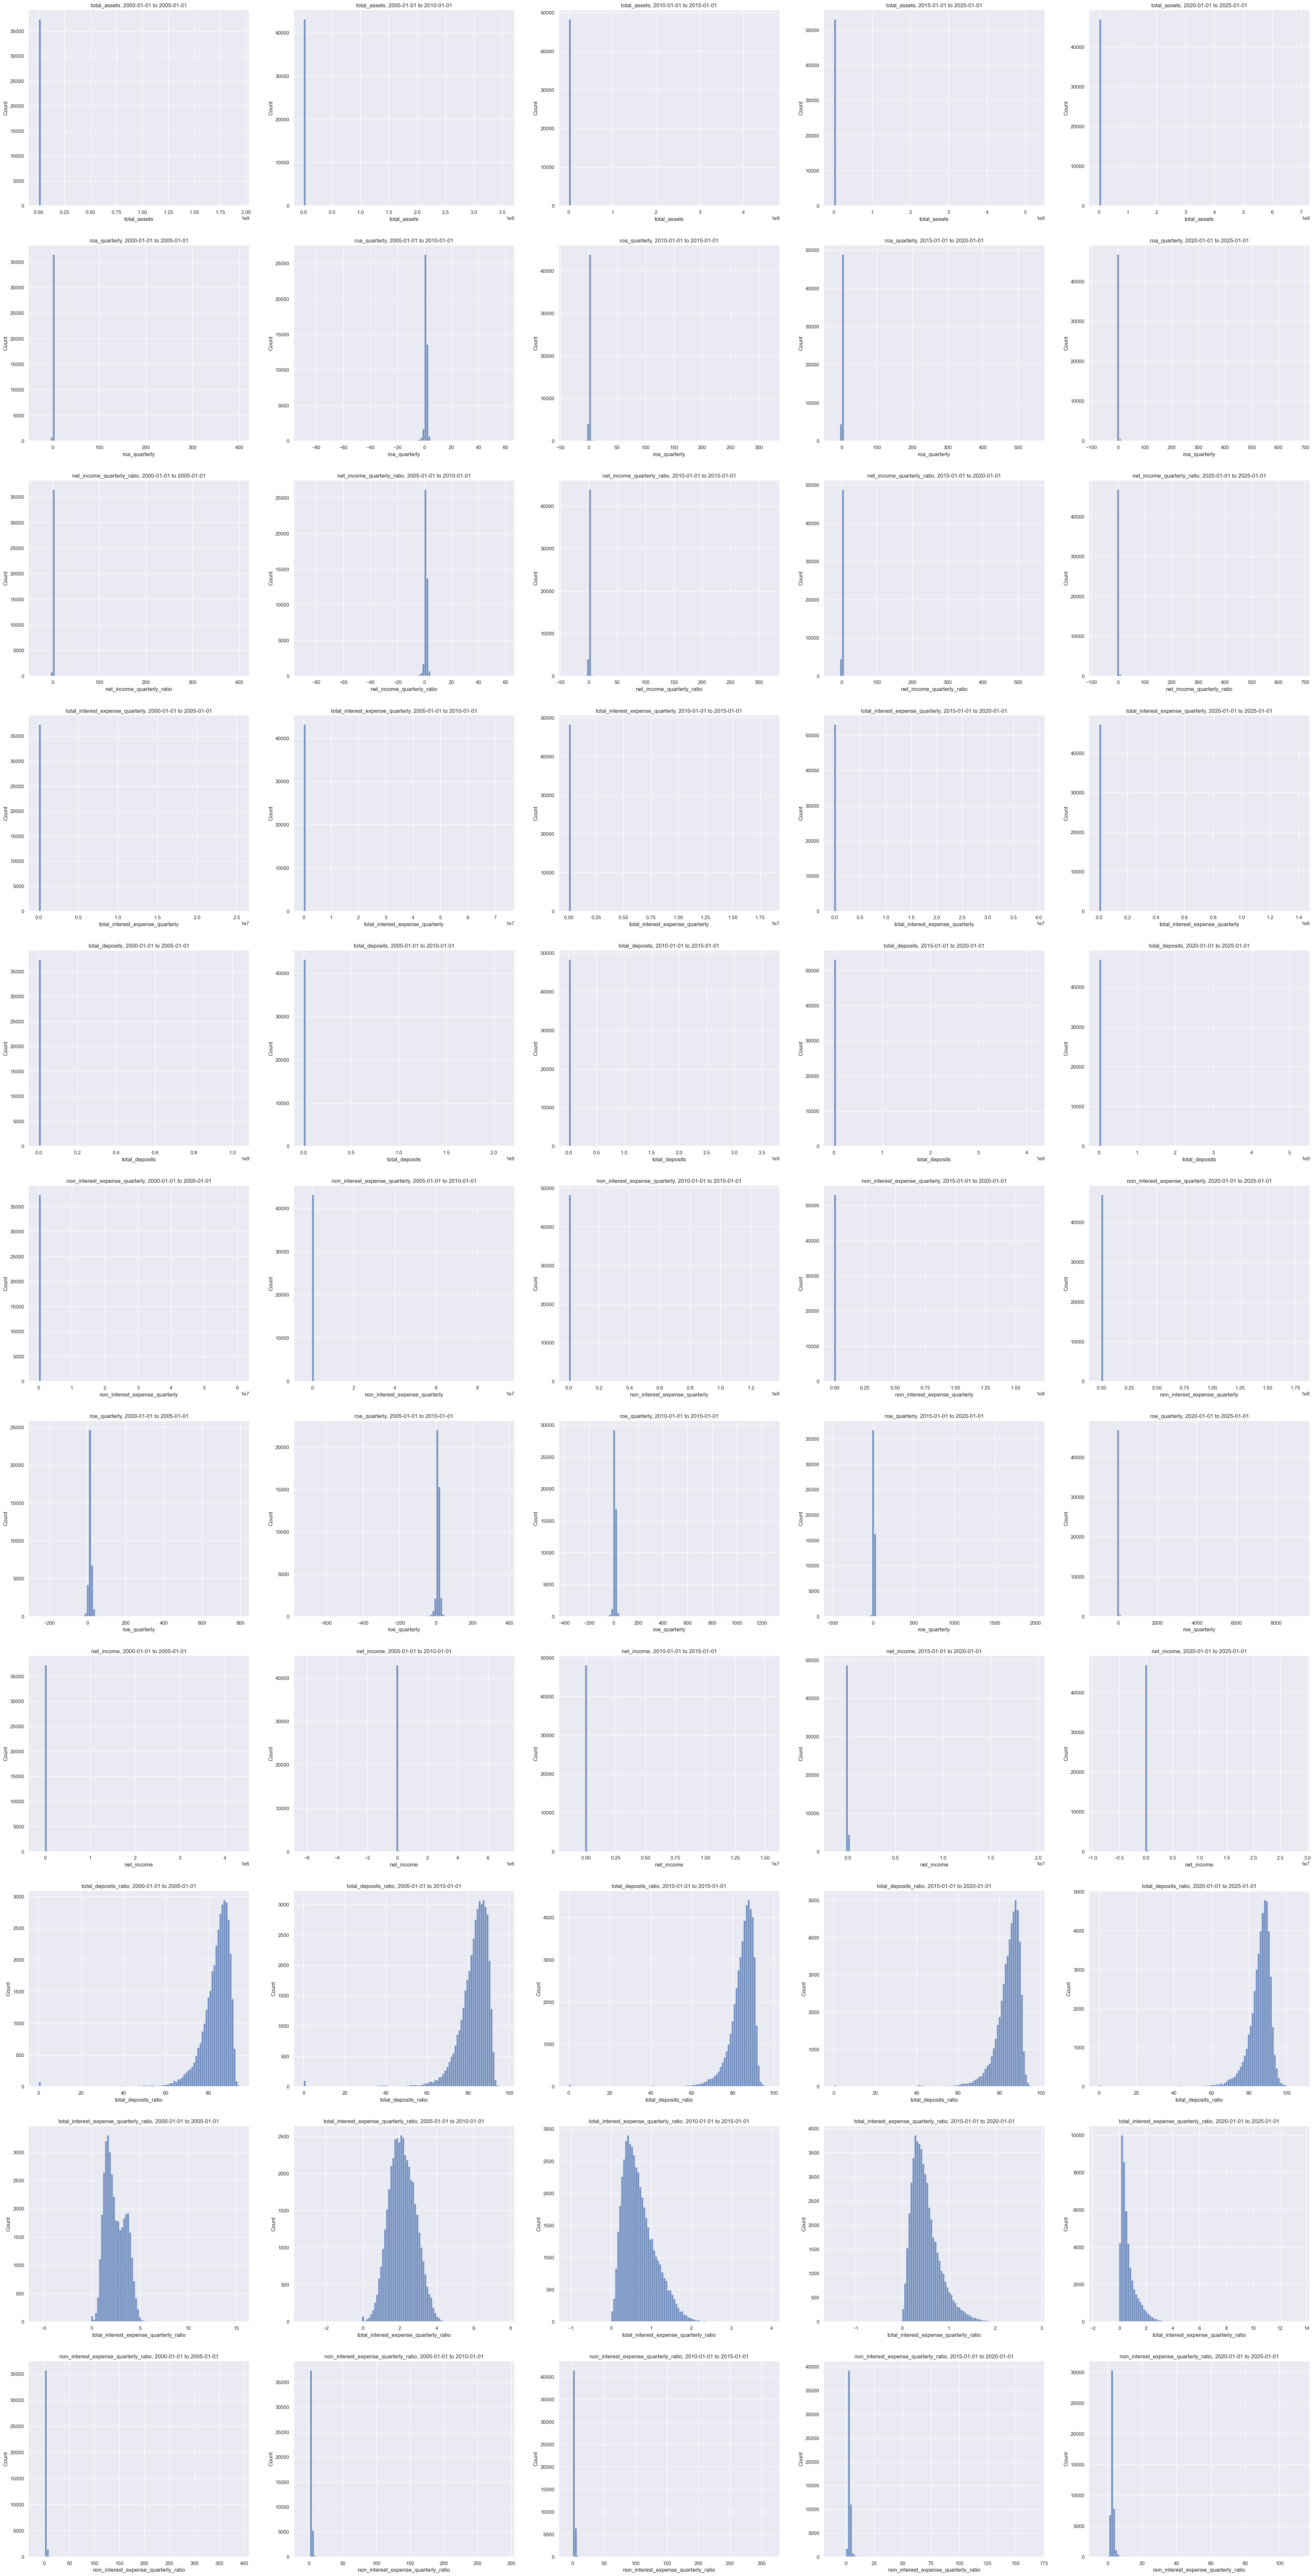

In [91]:
date_ranges = ["2000-01-01", "2005-01-01", "2010-01-01", "2015-01-01", "2020-01-01", "2025-01-01"]

fig, axes = plt.subplots(df_2000_agg.shape[1] - 5, len(date_ranges) - 1, figsize = (50, 100))

for i in range(1, len(date_ranges)):
    curr_data = df_2000_agg[(df_2000_agg["date"] >= date_ranges[i - 1]) &
                            (df_2000_agg["date"] < date_ranges[i])]
    for j in range(5, curr_data.shape[1]):
        metric = curr_data.columns[j]
        sns.histplot(curr_data, x = metric, bins = 100, ax = axes[j - 5, i - 1])
        axes[j - 5, i - 1].set_title(metric + ", " + date_ranges[i - 1] + " to " + date_ranges[i])

The ratios seem to generally follow a normal distribution (with some skew at times), while the absolute values seem to be extremely right-skewed. This matches what we would expect from the variables.

Finally, we scale and center the metrics so that they are all treated equally.

In [92]:
df_final = df_2000_agg.copy()
for i in df_final.columns[5:]:
    df_final[i] = df_final[i] - np.mean(df_final[i])  # Center values
    df_final[i] = df_final[i] / np.max(
        [np.nanmax(df_final[i]), np.nanmin(df_final[i]) * -1]
    )  # Scale values
df_final.head()

,category,state,city,zip,date,total_assets,roa_quarterly,net_income_quarterly_ratio,total_interest_expense_quarterly,total_deposits,non_interest_expense_quarterly,roe_quarterly,net_income,total_deposits_ratio,total_interest_expense_quarterly_ratio,non_interest_expense_quarterly_ratio
0,BANK OF AMERICA CORP,North Carolina,Charlotte,28202,2009-12-31,0.420946,-0.001772,-0.001772,0.135312,0.379992,0.402155,-0.001199,-0.005847,-0.183496,-0.038810,-0.001893
1,BANK OF AMERICA CORP,North Carolina,Charlotte,28202,2010-03-31,0.429899,-0.001271,-0.001265,0.112966,0.379212,0.393296,-0.000867,0.083265,-0.202104,-0.046291,-0.002027
2,BANK OF AMERICA CORP,North Carolina,Charlotte,28202,2010-06-30,0.436416,-0.001212,-0.001211,0.109766,0.381625,0.414924,-0.000829,0.094494,-0.209004,-0.048027,-0.001805
3,BANK OF AMERICA CORP,North Carolina,Charlotte,28202,2010-09-30,0.427849,-0.000371,-0.000366,0.103760,0.387220,0.392621,-0.000278,0.245108,-0.181394,-0.049930,-0.002133
4,BANK OF AMERICA CORP,North Carolina,Charlotte,28202,2010-12-31,0.425857,-0.000563,-0.000557,0.110818,0.393467,0.492853,-0.000418,0.208455,-0.164334,-0.047138,-0.000499


<a id="explo-summary"></a>
## Summary statistics

In [94]:
df_final.describe()

,date,total_assets,roa_quarterly,net_income_quarterly_ratio,total_interest_expense_quarterly,total_deposits,non_interest_expense_quarterly,roe_quarterly,net_income,total_deposits_ratio,total_interest_expense_quarterly_ratio,non_interest_expense_quarterly_ratio
count,230670,2.306700e+05,2.306700e+05,2.306700e+05,230670.000000,2.306700e+05,2.306700e+05,2.305870e+05,2.306700e+05,2.306700e+05,2.306700e+05,2.306700e+05
mean,2013-03-23 05:01:03.956301312,3.080343e-20,-2.310257e-19,1.197243e-19,0.000000,-9.241029e-20,6.160686e-20,-9.394817e-20,6.160686e-20,-1.401710e-16,8.162909e-19,1.619105e-18
min,2000-03-31 00:00:00,-8.511897e-04,-1.332607e-01,-1.332639e-01,-0.001354,-8.616509e-04,-2.459068e-02,-1.069280e-01,-3.067716e-01,-1.000000e+00,-4.756477e-01,-3.780150e-02
25%,2007-06-30 00:00:00,-8.368190e-04,-6.661457e-04,-6.678994e-04,-0.000287,-8.455627e-04,-8.225927e-04,-4.311946e-04,-5.367695e-04,-2.950922e-02,-5.611566e-02,-2.209362e-03
50%,2013-09-30 00:00:00,-8.183916e-04,-1.501560e-04,-1.533439e-04,-0.000278,-8.250083e-04,-8.030509e-04,-5.418424e-05,-5.238963e-04,1.984037e-02,-2.661569e-02,-1.015656e-03
75%,2019-03-31 00:00:00,-7.675626e-04,4.100614e-04,4.062283e-04,-0.000254,-7.691785e-04,-7.480922e-04,3.746737e-04,-4.877955e-04,5.534312e-02,4.106939e-02,3.344720e-04
max,2023-12-31 00:00:00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.775773e-01,1.000000e+00,1.000000e+00
std,NaN,1.808479e-02,8.631026e-03,8.630984e-03,0.007249,1.819132e-02,1.757455e-02,3.332534e-03,1.236682e-02,9.521720e-02,7.209574e-02,1.498108e-02


With the most prominent outliers removed, the summary statistics per metric look reasonable.

<a id="explo-corr"></a>
## Correlation heatmap

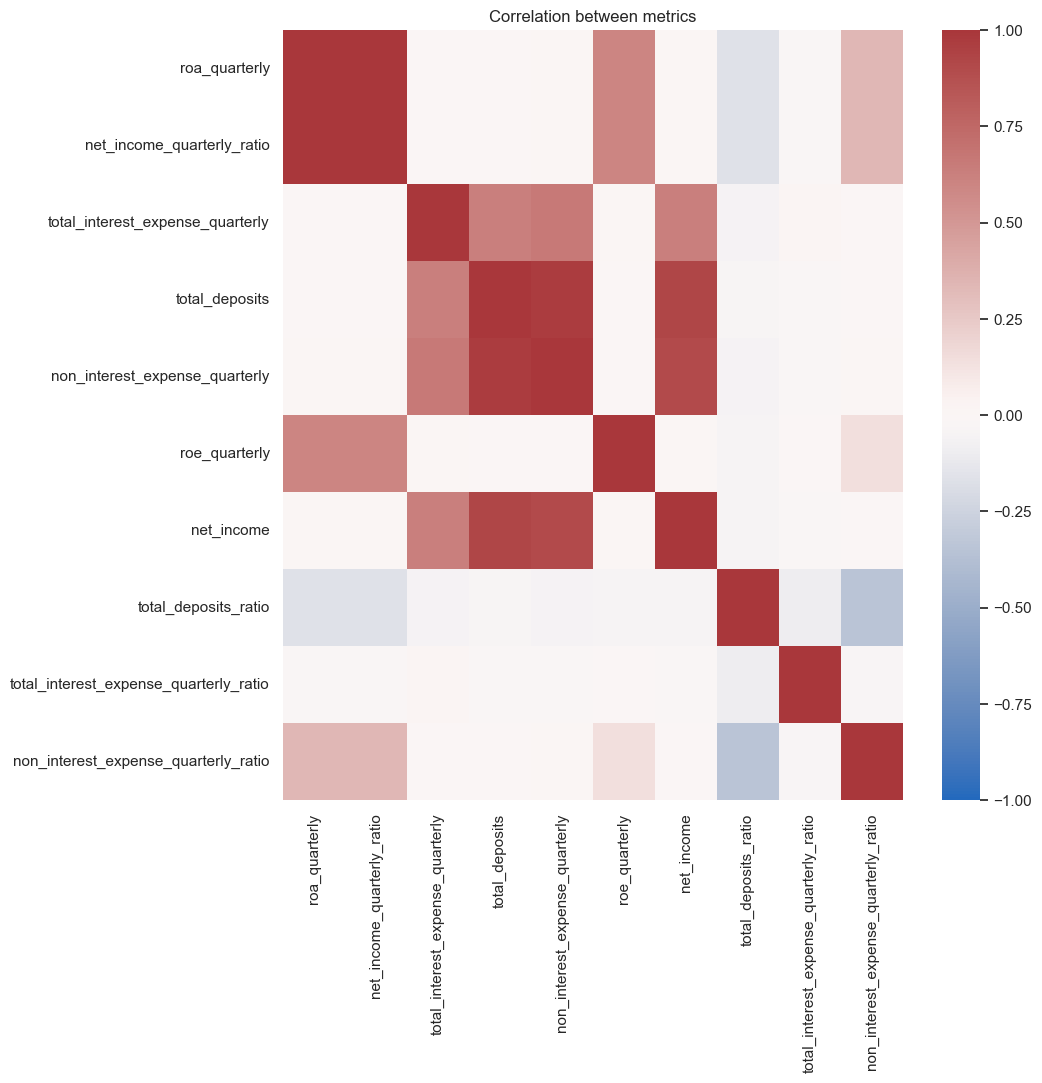

In [95]:
corr_columns = list(df_final.columns[6:])
sns.set(rc = {"figure.figsize": (10, 10)})
sns.heatmap(df_final[corr_columns].corr(), vmin = -1, vmax = 1, cmap="vlag").set_title(
    "Correlation between metrics"
)
plt.show()

As we can see, many metrics are highly correlated, which may create issues of collinearity. We will perform manual feature selection to accommodate for this.

<a id="unsupervised"></a>
# Unsupervised modelling exploration

<a id="supervised"></a>
# Supervised modelling and analysis

<a id="supervised-results"></a>
## Results